
## **Project Abstract** ## 
To help people get started on their project and to make sure you are selecting an appropriate task, we will have all the teams submit an abstract. Please only submit one abstract per team.

The abstract should include (at least):

-Team members

-Problem statement

-Data you will use to solve the problem

-Outline of how you plan on solving the problem with the data. For example, what pre-processing steps might you need to do, what models, etc.

-Supporting documents if necessary citing past research in the area and methods used to solve the problem.

-The goal of this abstract is for you to think deeply about the project you will be undertaking and convince yourself (and us) that it is a meaningful and achievable project for this class.

This homework is due March 1, 2018 by midnight Utah time. and will be submitted on learning suite.

# Airbnb New User Bookings

## Team Members

- Alex Fabiano 
- Michael Clawson
- Elijah Broadbent 


## Problem Statement



With 34,000+ cities across 190+ countries, Airbnb users have a multitude of destinations from which to choose.  This vast array of possibilities creates problems for both users and Airbnb. New users may suffer choice overload and prolong their first booking. Irregular and prolonged first bookings can cause demand lags and inhibit demand predictability for Airbnb.
	
The goal of this data project is to accurately predict where new users will book their first Airbnb. This will enable Airbnb to share more personalized content and better forecast demand as well as improve user experience.


## Data

The data for this project comes from four separate files containing age and gender buckets, countries, websession, and a user set.  We will need to join the users and sessions sets into a training set while the remaining sets will serve as supplementary information to inform our data cleaning and analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# from sklearn.metrics import f1_score, classification_report, accuracy_score, make_scorer
plt.rcParams['figure.figsize'] = [10,8]

In [2]:
test = pd.read_csv('test_users.csv')
#XY_Age = pd.read_csv('age_gender_bkts.csv') #complicated and messy...consider doing last
#countries = pd.read_csv('countries.csv')
users = pd.read_csv('train_users_2.csv')
sessions = pd.read_csv('sessions.csv')

Note that other refers to bookings made to a country not on this list while NDF corresponds to sessions in which no booking was ultimately made.

In [3]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
# joined = pd.merge(users, sessions, left_on='id', right_on='user_id', how='inner')
# joined.head()

In [5]:
print("Sessions Length: {}\tUsers Length: {}".format(len(sessions), len(users)))

Sessions Length: 10567737	Users Length: 213451


In [6]:
users.country_destination.value_counts(normalize=True, dropna=False)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

**Make Train/Test Split for Binary Classification Model**

In [156]:
#Create variable for whether a user booked at all
users['Booked?'] = np.where(users['date_first_booking'].isnull(), 0, 1) 
target = users['Booked?']
target2 = users['country_destination']
xtrain, xtest, ytrain, ytest = train_test_split(users.copy(), target, test_size=0.2, random_state=42)
#xtrain2, xtest2, ytrain2, ytest2 = train_test_split(users, target2, test_size=0.2, random_state=42)

## Data Cleaning and Feature Engineering

In [8]:
xtrain.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
Booked?                      int64
dtype: object

We have a lot of object types in our data that will need to be transformed if we choose to use them.  Let's set aside the variables we want to drop and the ones we want to convert into dummy variables.

In [9]:
# Create drop and dummy arrays
drop = []
dummies = []

In [10]:
# Displays the columns with null values and the percent of null values for each column
print("Columns\t\t\t % Null")
xtrain[xtrain.columns[xtrain.isnull().any()]].isnull().sum()/len(xtrain)

Columns			 % Null


date_first_booking         0.583860
age                        0.412573
first_affiliate_tracked    0.028789
dtype: float64

Date of booking null values indicate that no booking was ever made, so a high proportion of nulls in this category is no surprise. Age is the only glaring null-value issue with the data, as over 30% of values are missing. We may be able to find a way to fill these values with the average age conditional on the users other observable characteristics; e.g. female mac owners who use chrome.

In [11]:
drop.extend(['Booked?','country_destination','date_first_booking','id'])# Binary target extracted earlier

In [12]:
drop

['Booked?', 'country_destination', 'date_first_booking', 'id']

**Date Account Created**

In [13]:
xtrain.date_account_created.describe() #Need to extract usable variables

count         170760
unique          1632
top       2014-05-13
freq             535
Name: date_account_created, dtype: object

In [14]:
xtrain.date_account_created = pd.to_datetime(xtrain.date_account_created) #Casts object as datetime
xtest.date_account_created = pd.to_datetime(xtest.date_account_created)
test.date_account_created = pd.to_datetime(test.date_account_created)

In [15]:
# Create indicators for day of week (0=Mon, 6=Sun) account was created
xtrain['day_of_week_created'] = xtrain.date_account_created.dt.weekday
xtest['day_of_week_created'] = xtest.date_account_created.dt.weekday
test['day_of_week_created'] = test.date_account_created.dt.weekday
# Create indicators for day of month (0 through 31), month, and year account created
xtrain['day_of_month_created'] = xtrain['date_account_created'].dt.day
xtest['day_of_month_created'] = xtest['date_account_created'].dt.day
test['day_of_month_created'] = test['date_account_created'].dt.day
xtrain['month_created'] = xtrain['date_account_created'].dt.month
xtest['month_created'] = xtest['date_account_created'].dt.month
test['month_created'] = test['date_account_created'].dt.month
xtrain['year_created'] = xtrain['date_account_created'].dt.year
xtest['year_created'] = xtest['date_account_created'].dt.year
test['year_created'] = test['date_account_created'].dt.year

In [16]:
drop.append('date_account_created')

Do we really want date of first booking? It seems a bit silly to predict where people are booking when we already have the date. If we want to present something that's more realistic, we might want to try to predict based on historical info.

-- I think you make an excellent point...we should ask Tyler after class

-- I think we should put it in the model and let the model decide if it's useful.

According to Maria, we should not include the date of the first booking because the model will use that variable alone to predict, and new test data won't have that variable.

**Gender**

In [17]:
#What can we intuit from the gender variable?
xtrain['gender'].value_counts(normalize=True, dropna=False)

-unknown-    0.448313
FEMALE       0.295216
MALE         0.255177
OTHER        0.001294
Name: gender, dtype: float64

Unknown should be kept as a variable, and should not try to fill, given that it is very likely that the model will see unknown genders in the test set. 

In [18]:
dummies.append('gender')#??? only make dummies for 3 of them ('drop_first=True' makes k-1 dummies)

**Age**

In [19]:
xtrain.age.describe()

count    100309.000000
mean         49.658186
std         155.692226
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [20]:
print("% Individuals older than 100: {}".format(sum((xtrain.age > 100)/len(xtrain.age)).round(4)))
print("% Individuals younger than 18: {}".format((sum(xtrain.age < 18)/len(xtrain.age)).round(4)))

% Individuals older than 100: 0.011
% Individuals younger than 18: 0.0007


According to the age distribution statistics, it appears that the data contains individuals with implausible ages exceeding 120 years. We may be better suited to only include individuals under the age of 100 in our analysis and modeling.

In [21]:
# Statistics on individuals with age less than 100
xtrain[xtrain.age<100]['age'].describe()

count    98423.000000
mean        36.522988
std         11.654536
min          1.000000
25%         28.000000
50%         34.000000
75%         42.000000
max         99.000000
Name: age, dtype: float64

Text(0.5,1,'Age Distribution')

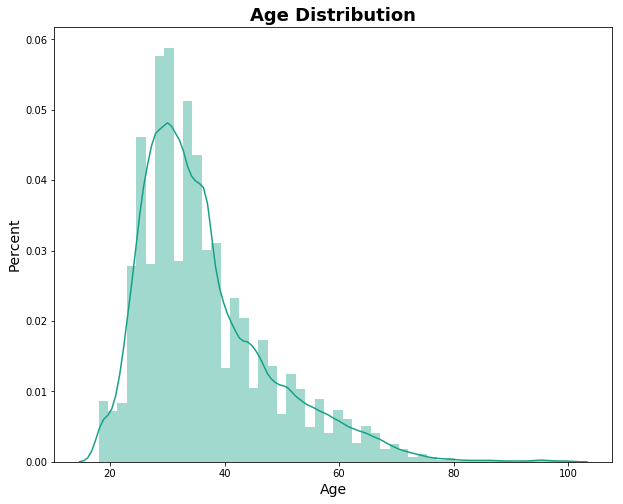

In [22]:
train_mean_age = xtrain[(xtrain.age<100) & (xtrain.age>18)].age.mean()
sns.distplot(xtrain['age'].apply(lambda x : train_mean_age if x>100 or x < 18 else x).dropna(), color='#16A085')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.title('Age Distribution', fontsize=18, fontweight='bold')

Most of our dataset is comprised of 25-40-year-olds, and there is a small number of users that are younger than Airbnb terms of service allow to book rooms.  We will also have to do address the bizarre ages in the thousands.

In [23]:
#Change all unusable ages to NaN:
xtrain.loc[xtrain.age > 95, 'age'] = np.nan
xtrain.loc[xtrain.age < 18, 'age'] = np.nan
xtest.loc[xtest.age > 95, 'age'] = np.nan
xtest.loc[xtest.age < 18, 'age'] = np.nan
test.loc[test.age > 95, 'age'] = np.nan
test.loc[test.age < 18, 'age'] = np.nan
# Airbnb users must be 18 by law...so does 13 make sense?

In [24]:
# Here is a neat way to impute missing age values
train_std_age = xtrain[(xtrain.age<100) & (xtrain.age>18)].age.std()
# Generate random ages within one standard deviation of the mean for train, xtest, and test sets respectively
rand1 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=xtrain.age.isnull().sum())
rand2 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=xtest.age.isnull().sum())
rand3 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=test.age.isnull().sum())

In [25]:
# Create a series to preserve the indices of NaNs
xtrain['age'] = xtrain['age'].fillna(pd.Series(rand1, xtrain[xtrain.age.isnull()].index))
xtest['age'] = xtest['age'].fillna(pd.Series(rand2, xtest[xtest.age.isnull()].index))
test['age'] = test['age'].fillna(pd.Series(rand3, test[test.age.isnull()].index))

**Signup Method**

In [26]:
#??? Should this be made into dummies or not?
users['signup_method'].value_counts(normalize=True, dropna=False)

basic       0.716310
facebook    0.281132
google      0.002558
Name: signup_method, dtype: float64

Signup Method is a rather straightforward dummy case, and there are no null values to fill in for, as per the null value analysis done previously in the notebook.

In [27]:
dummies.append('signup_method')

**Signup Flow**

The web page from which a user came to signup (discrete variable).

In [28]:
xtrain['signup_flow'].value_counts(normalize=True, dropna=False)

0     0.771598
25    0.068880
12    0.043816
3     0.041210
2     0.032109
24    0.020502
23    0.013147
1     0.004878
6     0.001482
8     0.001113
21    0.000925
5     0.000170
20    0.000070
16    0.000047
15    0.000041
4     0.000006
10    0.000006
Name: signup_flow, dtype: float64

In [29]:
# Replace values consisting of less than 0.1% of the data with the 'signup_flow' mode, 0
xtrain.signup_flow.replace(to_replace=[21,5,20,16,15,4,10], value=0, inplace=True)
xtest.signup_flow.replace(to_replace=[21,5,20,16,15,4,10], value=0, inplace=True)
test.signup_flow.replace(to_replace=[21,5,20,16,15,4,10], value=0, inplace=True)

In [30]:
dummies.append('signup_flow')

**Language**

In [31]:
xtrain.language.value_counts(normalize=True, dropna=False)

en    0.966438
zh    0.007748
fr    0.005493
es    0.004257
de    0.003443
ko    0.003414
it    0.002430
ru    0.001927
pt    0.001136
ja    0.001001
sv    0.000533
nl    0.000480
tr    0.000287
pl    0.000275
da    0.000264
cs    0.000164
no    0.000146
el    0.000129
id    0.000100
hu    0.000094
th    0.000088
fi    0.000082
ca    0.000029
is    0.000029
hr    0.000012
Name: language, dtype: float64

Since 96% of all users speak English, the language variable may provide little insight. Making dummies for all of the languages seems illogical. We could consider creating dummies for English (eh), Chinese (zh), and an 'other' category.

In [32]:
xtrain.language = xtrain.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')
xtest.language = xtest.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')
test.language = test.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')

In [33]:
dummies.append('language')

**Affiliate Channel**

In [34]:
xtrain.affiliate_channel.value_counts(normalize=True, dropna=False)

direct           0.645122
sem-brand        0.121305
sem-non-brand    0.088785
other            0.042457
seo              0.040700
api              0.038358
content          0.018107
remarketing      0.005165
Name: affiliate_channel, dtype: float64

In [35]:
dummies.append('affiliate_channel')

**Affiliate Provider**

In [36]:
xtrain.affiliate_provider.value_counts(normalize=True, dropna=False)

direct                 0.643640
google                 0.241614
other                  0.059241
craigslist             0.016544
bing                   0.011097
facebook               0.010606
vast                   0.003842
padmapper              0.003613
facebook-open-graph    0.002588
yahoo                  0.002290
gsp                    0.002073
meetup                 0.001628
email-marketing        0.000755
naver                  0.000234
baidu                  0.000129
yandex                 0.000070
wayn                   0.000029
daum                   0.000006
Name: affiliate_provider, dtype: float64

In [37]:
#??? Either make dummies for all or only the categories consisting of more than 3%
xtrain.affiliate_provider = xtrain.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
xtest.affiliate_provider = xtest.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
test.affiliate_provider = test.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
dummies.append('affiliate_provider')

**First Affiliate Tracked**

First marketing interacted with by the user before signing up.

In [38]:
xtrain.first_affiliate_tracked.value_counts(normalize=True, dropna=False)

untracked        0.510606
linked           0.217270
omg              0.206055
tracked-other    0.029035
NaN              0.028789
product          0.007408
marketing        0.000673
local ops        0.000164
Name: first_affiliate_tracked, dtype: float64

In [39]:
# Fills null values with variable mode, which is 'untracked'
xtrain.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
xtest.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
test.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
dummies.append('first_affiliate_tracked')

**Signup App**

In [40]:
xtrain.signup_app.value_counts(normalize=True, dropna=False)

Web        0.855651
iOS        0.089506
Moweb      0.029351
Android    0.025492
Name: signup_app, dtype: float64

In [41]:
dummies.append('signup_app')

**First Device Type**

In [42]:
xtrain.first_device_type.value_counts(normalize=True, dropna=False)

Mac Desktop           0.419320
Windows Desktop       0.340976
iPhone                0.097242
iPad                  0.067071
Other/Unknown         0.050158
Android Phone         0.013317
Android Tablet        0.006108
Desktop (Other)       0.005452
SmartPhone (Other)    0.000357
Name: first_device_type, dtype: float64

In [43]:
dummies.append('first_device_type')

**First Browser**

In [44]:
xtrain.first_browser.value_counts(normalize=True, dropna=False)

Chrome                  0.298969
Safari                  0.210957
Firefox                 0.157900
-unknown-               0.127987
IE                      0.098969
Mobile Safari           0.090015
Chrome Mobile           0.006196
Android Browser         0.004035
AOL Explorer            0.001113
Opera                   0.000896
Silk                    0.000597
Chromium                0.000328
BlackBerry Browser      0.000246
Maxthon                 0.000240
Apple Mail              0.000176
Mobile Firefox          0.000152
IE Mobile               0.000152
Sogou Explorer          0.000146
SiteKiosk               0.000141
RockMelt                0.000123
Iron                    0.000082
Pale Moon               0.000064
IceWeasel               0.000059
Yandex.Browser          0.000053
CometBird               0.000047
Camino                  0.000047
TenFourFox              0.000041
wOSBrowser              0.000035
SeaMonkey               0.000035
CoolNovo                0.000035
Opera Mini

In [45]:
vlist = ['Chrome', 'Safari', '-unknown-', 'Firefox', 'Mobile Safari', 'IE']
xtrain.first_browser = xtrain.first_browser.apply(lambda x: x if str(x) in vlist else 'other')
xtest.first_browser = xtest.first_browser.apply(lambda x: x if str(x) in vlist else 'other')
test.first_browser = test.first_browser.apply(lambda x: x if str(x) in vlist else 'other')

In [46]:
dummies.append('first_browser')

**Where possible, we should make sure the 'NDF' group is comparable on other observable characteristics. We can go back and add visualizations in the data cleaning section**

In [47]:
xtrain.country_destination.value_counts(normalize=True, dropna=False)

NDF      0.583860
US       0.291936
other    0.047365
FR       0.023501
IT       0.013311
GB       0.010699
ES       0.010529
CA       0.006752
DE       0.004995
NL       0.003555
AU       0.002489
PT       0.001007
Name: country_destination, dtype: float64

In [48]:
xtrain.drop(drop, axis=1, inplace=True)
xtest.drop(drop, axis=1, inplace=True)
test.drop(drop[2:], axis=1, inplace=True)

In [49]:
xtrain = pd.get_dummies(xtrain, columns=dummies)
xtest = pd.get_dummies(xtest, columns=dummies)
test = pd.get_dummies(test, columns=dummies)

## Modeling

We first create a binary classification model to predict whether or not an individual will book an Airbnb. Our second model will then classify to which country a user will first visit given that they book a trip.

### K-Neighbors Classifier

In [53]:
%%timeit
kn_clf = KNeighborsClassifier()

In [54]:
%%timeit
gridsearch_kn = GridSearchCV(kn_clf, {"n_neighbors": [3,5,7], "weights": ['uniform', 'distance'],
                                  "p":[1,2,3]})
gridsearch_kn.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_kn.best_params_))
knclf_ypredict_train = gridsearch_kn.predict(xtrain)
print("Training Accuracy Score: {}".format(metrics.accuracy_score(ytrain, knclf_ypredict_train)))

Best Parameters: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Training Accuracy Score: 0.675474349964863


In [55]:
knclf_ypredict_test = gridsearch_kn.predict(xtest)

In [56]:
print("Test Accuracy Score: {}".format(metrics.accuracy_score(ytest, knclf_ypredict_test)))

Test Accuracy Score: 0.5389192101379682


### Random Forest

In [84]:
rf_clf = RandomForestClassifier()
gridsearch_rf = GridSearchCV(rf_clf, {"n_estimators": [60, 100, 200], "class_weight": ['balanced', None],
                                      "max_depth": [7,9,11]})

In [85]:
gridsearch_rf.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_rf.best_params_))
rfclf_ypredict_train = gridsearch_rf.predict(xtrain)

Best Parameters: {'class_weight': None, 'max_depth': 11, 'n_estimators': 200}


In [86]:
print("Test Classification Report:")
rfclf_ypredict_test = gridsearch_rf.predict(xtest)
print(metrics.classification_report(ytest, rfclf_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain, rfclf_ypredict_train),
                                                    metrics.accuracy_score(ytest, rfclf_ypredict_test)))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.68      0.80      0.74     24843
          1       0.64      0.48      0.55     17848

avg / total       0.67      0.67      0.66     42691

Train Accuracy: 0.680311548371984
Test Accuracy: 0.6704457614017006


In [139]:
# Selects xtrain indices from multiclass target2 and creates new ytrain series
ytrain2 = target2[xtrain.index][target2!='NDF']

In [153]:
xtrain2 = xtrain.loc[ytrain2.index]

In [149]:
ytest2 = target2[xtest.index][target2!='NDF']

In [161]:
xtest2 = xtest.loc[ytest2.index]

In [162]:
rf_clf2 = RandomForestClassifier()
gridsearch_rf2  = GridSearchCV(rf_clf2, {"n_estimators": [60, 100, 200], "class_weight": ['balanced', None],
                                      "max_depth": [7,9,11]})

In [163]:
gridsearch_rf2.fit(xtrain2, ytrain2)
print("Best Parameters: {}".format(gridsearch_rf2.best_params_))
rfclf2_ypredict_train = gridsearch_rf2.predict(xtrain2)

KeyboardInterrupt: 

# Project Research

Based on the other Kaggle kernels for this project, a few different methods have been used to predict first booking location for new Airbnb users. Some competitors utilized the ensemble technique, incorporating up to three layers. One kaggler implemented a three tiered ensemble with six different models in each layer (Support Vector Machines, Logistic Regression, Random Forest, Gradient Boosting, Extra Trees Classifier, and K-Nearest Neighbors). Another kaggler coded a Normalized Discounted Cumulative Gain model, or NDCG, which is a type of ranking measure. This model relies on a logarithmic discounting factor and has achieved significant empirical results. However, little is known about the theoretical properties of NDCG models. Further information can be found at https://arxiv.org/abs/1304.6480 .

# Strategy

After merging our data and doing a minimal amount of initial cleaning, we will use a K-Neighbors Classifier to get a naive baseline for our classification problem.  From there we will modify our cleaning as needed to account for outliers, missing data, and optimal control variables in a more robust fashion.  Other models we plan to consult include Random Forest, regression, and Gradient Boosting.  Depending on the results we obtain from these methods we can complicate our approach using tiered-ensembles of multiple models.